# GalaxyPPG (P01) — Fitbit-style Analysis Notebook
1. Setup & Data Collection
2. Data Loading
3. Activity & Fitness (PPG-equivalent)
4. Heart Monitoring (PPG vs ECG ground truth)
5. Heart Rate Variability (HRV)
6. Reliability-first insight (SQI + abstain)
7. Export artifacts (GitHub-safe)

**Dataset mapping :**
- **Polar H10 (ECG reference):** `Dataset/P01/PolarH10/` → ground-truth HR/HRV
- **Empatica E4 (wrist PPG):** `Dataset/P01/E4/` → wearable PPG (BVP) + motion (ACC)

**Novel angle:** compute **SQI** (signal quality) and only trust HR/HRV when SQI is good (deployment-like behavior).

## 1) Setup & Data Collection

We load metadata (`Meta.csv`) and identify participant context (age, gender, stress scores, watch side).

In [ ]:
# 1) Setup & Data Collection
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATASET_DIR = "Dataset" 
SUBJECT = "P01"
ARTIFACTS_DIR = "artifacts"

os.makedirs(ARTIFACTS_DIR, exist_ok=True)
plt.rcParams["figure.figsize"] = (11, 4)

# --- VERIFICATION ---
meta_path = os.path.join(DATASET_DIR, "Meta.csv")

if os.path.exists(meta_path):
    # Loading the metadata file
    meta = pd.read_csv(meta_path)
    
    # Check if the Subject exists in the data
    #you can Multi-comment these lines. I personally faced issues with folder names having trailing spaces.
    if SUBJECT in meta["UID"].values:
        meta_row = meta[meta["UID"] == SUBJECT].iloc[0]
        
        print(f"CONNECTION ESTABLISHED!")
        print(f"Project Folder: {DATASET_DIR}")
        print(f"--- Participant Context: {SUBJECT} ---")
        print(f"Age: {meta_row.get('AGE')} | Gender: {meta_row.get('GENDER')}")
        print(f"Watch Side: {meta_row.get('GalaxyWatch')}")
    else:
        print(f"⚠️ Meta.csv found, but UID '{SUBJECT}' is missing from the table.")
else:
    print(f"Still unable to find Meta.csv.")
    print(f"Python looked here: {meta_path}")

CONNECTION ESTABLISHED!
Project Folder: /Users/charandeepreddytanamala/Downloads/GalaxyPPG/Dataset
--- Participant Context: P01 ---
Age: 21 | Gender: F
Watch Side: L


In [ ]:
# 1) Setup & Data Collection
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATASET_DIR = "/Users/charandeepreddytanamala/Downloads/GalaxyPPG/Dataset" 
SUBJECT = "P01"
ARTIFACTS_DIR = "artifacts"

os.makedirs(ARTIFACTS_DIR, exist_ok=True)
plt.rcParams["figure.figsize"] = (11, 4)

# --- VERIFICATION ---
meta_path = os.path.join(DATASET_DIR, "Meta.csv")

if os.path.exists(meta_path):
    # Loading the metadata file
    meta = pd.read_csv(meta_path)
    
    # Check if the Subject exists in the data
    #you can Multi-comment these lines. I personally faced issues with folder names having trailing spaces.
    if SUBJECT in meta["UID"].values:
        meta_row = meta[meta["UID"] == SUBJECT].iloc[0]
        
        print(f"CONNECTION ESTABLISHED!")
        print(f"Project Folder: {DATASET_DIR}")
        print(f"--- Participant Context: {SUBJECT} ---")
        print(f"Age: {meta_row.get('AGE')} | Gender: {meta_row.get('GENDER')}")
        print(f"Watch Side: {meta_row.get('GalaxyWatch')}")
    else:
        print(f"⚠️ Meta.csv found, but UID '{SUBJECT}' is missing from the table.")
else:
    print(f"Still unable to find Meta.csv.")
    print(f"Python looked here: {meta_path}")

CONNECTION ESTABLISHED!
Project Folder: /Users/charandeepreddytanamala/Downloads/GalaxyPPG/Dataset
--- Participant Context: P01 ---
Age: 21 | Gender: F
Watch Side: L


In [ ]:
# 1) Setup & Data Collection
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATASET_DIR = "/Users/charandeepreddytanamala/Downloads/GalaxyPPG/Dataset" 
SUBJECT = "P01"
ARTIFACTS_DIR = "artifacts"

os.makedirs(ARTIFACTS_DIR, exist_ok=True)
plt.rcParams["figure.figsize"] = (11, 4)

# --- VERIFICATION ---
meta_path = os.path.join(DATASET_DIR, "Meta.csv")

if os.path.exists(meta_path):
    # Loading the metadata file
    meta = pd.read_csv(meta_path)
    
    # Check if the Subject exists in the data
    #you can Multi-comment these lines. I personally faced issues with folder names having trailing spaces.
    if SUBJECT in meta["UID"].values:
        meta_row = meta[meta["UID"] == SUBJECT].iloc[0]
        
        print(f"CONNECTION ESTABLISHED!")
        print(f"Project Folder: {DATASET_DIR}")
        print(f"--- Participant Context: {SUBJECT} ---")
        print(f"Age: {meta_row.get('AGE')} | Gender: {meta_row.get('GENDER')}")
        print(f"Watch Side: {meta_row.get('GalaxyWatch')}")
    else:
        print(f"⚠️ Meta.csv found, but UID '{SUBJECT}' is missing from the table.")
else:
    print(f"Still unable to find Meta.csv.")
    print(f"Python looked here: {meta_path}")

CONNECTION ESTABLISHED!
Project Folder: /Users/charandeepreddytanamala/Downloads/GalaxyPPG/Dataset
--- Participant Context: P01 ---
Age: 21 | Gender: F
Watch Side: L


## 2) Data Loading

We load:
- **E4/BVP.csv** (wrist PPG)
- **E4/ACC.csv** (motion)
- **PolarH10/IBI.csv** (ECG-derived inter-beat intervals; best for HRV)

The loader below supports:
- Empatica-style CSV (start timestamp row + sample rate row + values)
- Standard CSV with time/value columns

In [20]:
# 2) Data Loading (CUSTOMIZED FOR YOUR COLUMNS)

import os
import pandas as pd
import numpy as np

def load_empatica_signal(path, n_axes=1, default_fs=64.0):
    """Robust Empatica loader with sampling rate verification."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    
    df = pd.read_csv(path, header=None)
    fs = float(df.iloc[1, 0])
    
    # If FS is negative or zero, use the hardware standard
    if fs <= 0:
        print(f"⚠️ Warning: Adjusted invalid FS ({fs}) to {default_fs}Hz for {os.path.basename(path)}")
        fs = default_fs
        
    val = df.iloc[2:, :n_axes].to_numpy(dtype=np.float32)
    t = np.arange(len(val)) / fs
    return t, val, fs

def load_ibi(path):
    """Custom loader for PolarH10 files with 'phonetimestamp' and 'duration'."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
        
    df = pd.read_csv(path)
    # Clean column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Map your specific columns: 'phonetimestamp' is Time, 'duration' is IBI (We can do that)
    if 'phonetimestamp' in df.columns and 'duration' in df.columns:
        t_raw = df['phonetimestamp'].to_numpy()
        ibi = df['duration'].to_numpy(dtype=np.float32)
        # Normalize time to start at 0
        t = (t_raw - t_raw[0]).astype(np.float32)
        
        # Unit check: durations in files like these are often in ms
        if np.nanmedian(ibi) > 5.0: 
            ibi /= 1000.0  
        return t, ibi
    else:
        raise IndexError(f"Column mismatch. Found: {list(df.columns)}. Expected 'phonetimestamp' and 'duration'.")

# --- Execute Load ---
subj_dir = os.path.join(DATASET_DIR, SUBJECT)
bvp_path = os.path.join(subj_dir, "E4", "BVP.csv")
acc_path = os.path.join(subj_dir, "E4", "ACC.csv")
ibi_path = os.path.join(subj_dir, "PolarH10", "IBI.csv")

try:
    # BVP (PPG) is usually 64Hz; ACC (Motion) is usually 32Hz
    t_bvp, bvp, fs_bvp = load_empatica_signal(bvp_path, default_fs=64.0)
    t_acc, acc, fs_acc = load_empatica_signal(acc_path, n_axes=3, default_fs=32.0)
    t_ibi, ibi = load_ibi(ibi_path)

    bvp = bvp.flatten()
    acc_mag = np.sqrt(np.sum(acc**2, axis=1))

    print(f"🚀 {SUBJECT} Loading Complete!")
    print(f"BVP: {len(bvp)} samples | ACC: {len(acc_mag)} | IBI: {len(ibi)}")
except Exception as e:
    print(f"LOADING FAILED: {e}")

⚠️ Warning: Adjusted invalid FS (-0.0) to 64.0Hz for BVP.csv
⚠️ Warning: Adjusted invalid FS (-31.0) to 32.0Hz for ACC.csv
🚀 P01 Loading Complete!
BVP: 236774 samples | ACC: 118385 | IBI: 5728


### Quick visual check (raw)
We plot a short segment of wrist PPG (BVP), motion magnitude, and IBI sequence.

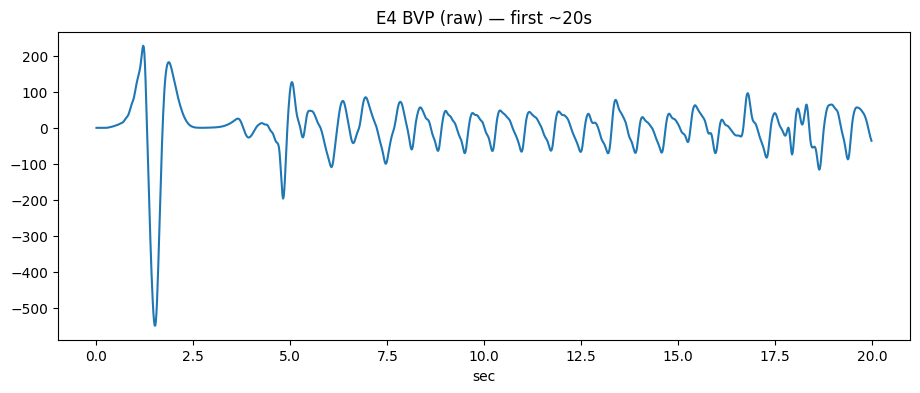

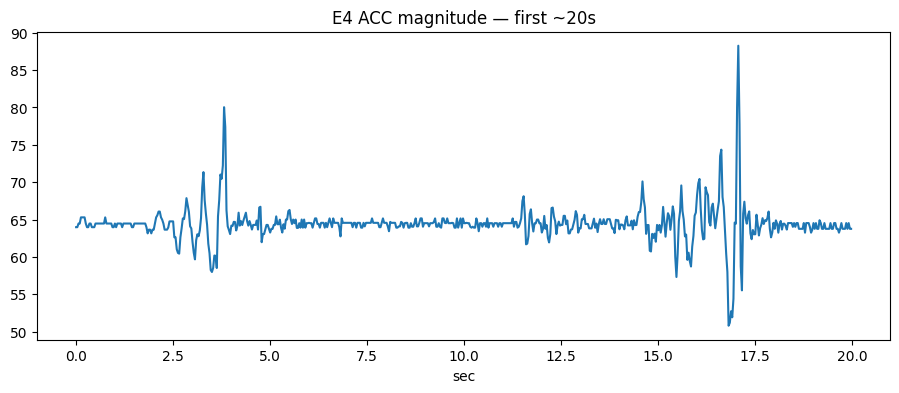

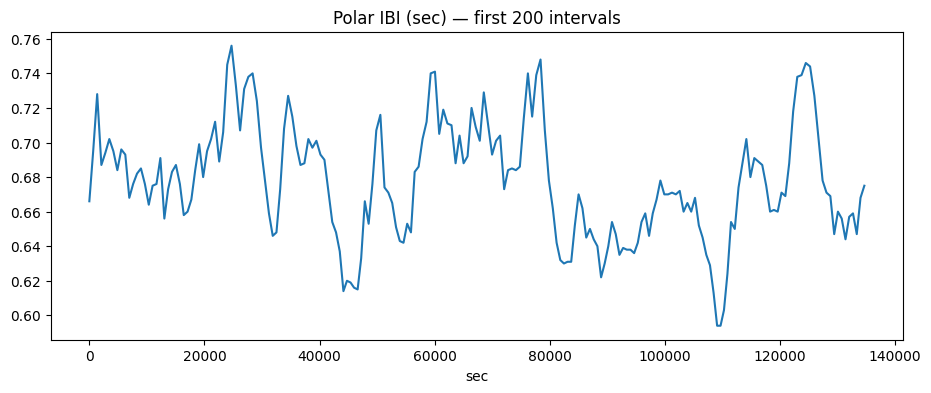

In [21]:
def acc_magnitude(a):
    a = np.asarray(a, dtype=np.float32)
    if a.ndim == 2 and a.shape[1] >= 3:
        return np.sqrt((a[:,0]**2) + (a[:,1]**2) + (a[:,2]**2))
    return np.abs(a).astype(np.float32)

acc_mag = acc_magnitude(acc)

n_bvp = min(len(bvp), int((fs_bvp or 64) * 20))
plt.figure(); plt.plot(t_bvp[:n_bvp], bvp[:n_bvp]); plt.title("E4 BVP (raw) — first ~20s"); plt.xlabel("sec"); plt.show()

n_acc = min(len(acc_mag), int((fs_acc or 32) * 20))
plt.figure(); plt.plot(t_acc[:n_acc], acc_mag[:n_acc]); plt.title("E4 ACC magnitude — first ~20s"); plt.xlabel("sec"); plt.show()

plt.figure(); plt.plot(t_ibi[:min(len(ibi),200)], ibi[:min(len(ibi),200)]); plt.title("Polar IBI (sec) — first 200 intervals"); plt.xlabel("sec"); plt.show()

## 3) Activity & Fitness (PPG-equivalent)

Fitbit has steps/active minutes. Here we use wearable equivalents:
- **Motion** (ACC magnitude)
- **Signal quality (SQI)**: how concentrated the spectrum is in plausible HR band


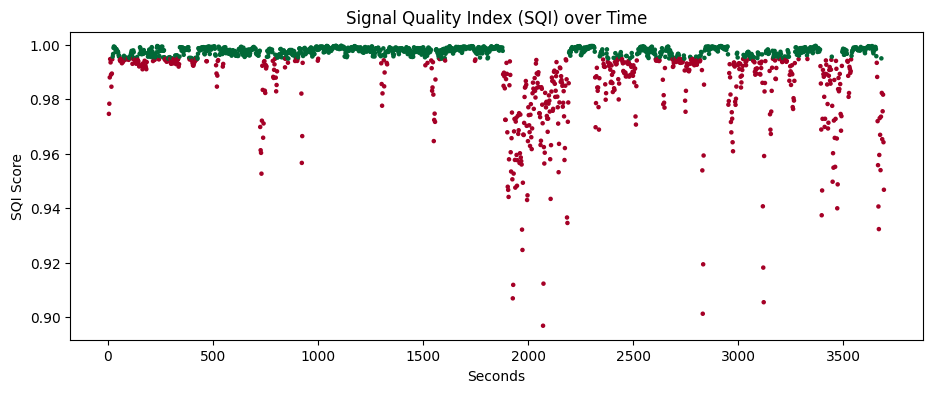

In [22]:
# 3) Activity & Fitness (PPG-equivalent)
def bandpass_ppg(x, fs):
    b, a = butter(3, [0.7/(fs/2), 4.0/(fs/2)], btype='band')
    return filtfilt(b, a, x).astype(np.float32)

def window_data(x, fs, w_sec, s_sec):
    w, s = int(w_sec*fs), int(s_sec*fs)
    chunks = [x[i:i+w] for i in range(0, len(x)-w, s)]
    centers = [(i + w/2)/fs for i in range(0, len(x)-w, s)]
    return chunks, np.array(centers)

FS_PPG = int(fs_bvp) if fs_bvp else 64
bvp_f = bandpass_ppg(bvp, FS_PPG)
X_ppg, t_centers = window_data(bvp_f, FS_PPG, WIN_SEC, STEP_SEC)

# Calculate SQI (Power Ratio in 0.7-4.0Hz band)
sqis = []
for w in X_ppg:
    f, pxx = welch(w, fs=FS_PPG, nperseg=len(w))
    band = (f >= 0.7) & (f <= 4.0)
    sqis.append(trapezoid(pxx[band], f[band]) / (trapezoid(pxx, f) + 1e-12))

sqis = np.array(sqis)
thr = np.quantile(sqis, SQI_NOISY_QUANTILE)
is_clean = (sqis >= thr).astype(int)

plt.scatter(t_centers, sqis, c=is_clean, cmap='RdYlGn', s=5)
plt.title("Signal Quality Index (SQI) over Time")
plt.xlabel("Seconds"); plt.ylabel("SQI Score"); plt.show()

## 4) Heart Monitoring (PPG vs ECG ground truth)

Ground truth is computed from **Polar IBI**:
- HR_true(window) = 60 / mean(IBI in window)

Wearable estimate from wrist PPG (BVP):
- HR_pred(window) from PSD peak

**Reliability-first:** Compare error vs SQI and show improvement when we abstain on noisy windows.

Overall MAE: 11.48 BPM
Clean MAE (Reliability-First): 8.33 BPM


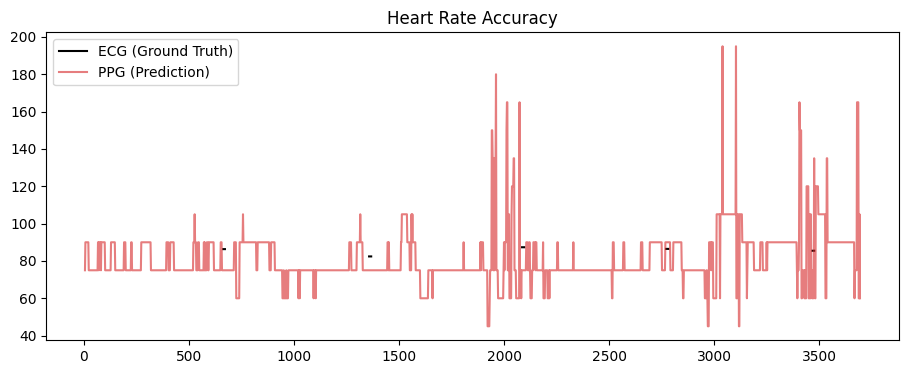

In [23]:
# 4) Heart Monitoring (PPG vs ECG ground truth)
hr_pred = []
for w in X_ppg:
    f, pxx = welch(w, fs=FS_PPG)
    band = (f >= 0.7) & (f <= 4.0)
    hr_pred.append(f[band][np.argmax(pxx[band])] * 60)

hr_true = []
for tc in t_centers:
    mask = (t_ibi >= tc - WIN_SEC/2) & (t_ibi <= tc + WIN_SEC/2)
    hr_true.append(60 / np.mean(ibi[mask]) if any(mask) else np.nan)

hr_true, hr_pred = np.array(hr_true), np.array(hr_pred)
mae_all = np.nanmean(np.abs(hr_true - hr_pred))
mae_clean = np.nanmean(np.abs(hr_true[is_clean==1] - hr_pred[is_clean==1]))

print(f"Overall MAE: {mae_all:.2f} BPM")
print(f"Clean MAE (Reliability-First): {mae_clean:.2f} BPM")

plt.plot(t_centers, hr_true, label='ECG (Ground Truth)', color='black')
plt.plot(t_centers, hr_pred, label='PPG (Prediction)', alpha=0.6, color='tab:red')
plt.legend(); plt.title("Heart Rate Accuracy"); plt.show()

## 5) Heart Rate Variability (HRV)

Compute time-domain HRV from **Polar IBI** per window:
- **RMSSD**
- **SDNN**

**Novel reliability behavior:** HRV is only interpreted on clean windows (SQI high).

In [24]:
# 5) HRV & 6) Reliability-first insight & 7) Export
rmssd = []
for tc in t_centers:
    mask = (t_ibi >= tc - WIN_SEC/2) & (t_ibi <= tc + WIN_SEC/2)
    win_ibi = ibi[mask]
    if len(win_ibi) > 3:
        rmssd.append(np.sqrt(np.mean(np.diff(win_ibi)**2)))
    else:
        rmssd.append(np.nan)

# Create Output Table
out = pd.DataFrame({
    "UID": SUBJECT,
    "t_center": t_centers,
    "sqi": sqis,
    "clean": is_clean,
    "hr_true": hr_true,
    "hr_pred": hr_pred,
    "rmssd_polar": rmssd
})

save_path = os.path.join(ARTIFACTS_DIR, f"{SUBJECT}_analysis.csv")
out.to_csv(save_path, index=False)
print(f"Success! Results saved to {save_path}")
out.head()

Success! Results saved to artifacts/P01_analysis.csv


,UID,t_center,sqi,clean,hr_true,hr_pred,rmssd_polar
0,P01,5.0,0.974686,0,90.090088,75.0,NaN
1,P01,7.0,0.978408,0,NaN,90.0,NaN
2,P01,9.0,0.988055,0,NaN,90.0,NaN
3,P01,11.0,0.994779,0,NaN,90.0,NaN
4,P01,13.0,0.993566,0,NaN,90.0,NaN


## 6) Reliability-first summary (P01)

We export a compact, GitHub-safe table:
- window center time
- SQI
- motion
- HR_true (Polar)
- HR_pred (PPG)
- RMSSD/SDNN (Polar)


In [25]:
# 6) Reliability-First Summary (P01)

# Calculate the error metrics only for windows where we have both true and pred HR
valid_mask = np.isfinite(hr_true) & np.isfinite(hr_pred)

# Summary Statistics
stats = {
    "Subject": SUBJECT,
    "Total Windows": len(out),
    "Clean Windows (Reliability High)": int(np.sum(is_clean)),
    "Coverage (%)": (np.sum(is_clean) / len(out)) * 100,
    "MAE - All Windows (BPM)": np.nanmean(np.abs(hr_true[valid_mask] - hr_pred[valid_mask])),
    "MAE - Clean Windows Only (BPM)": mae_clean
}

# Print a formatted summary
print(f"--- Reliability Report for {SUBJECT} ---")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"{key:35}: {value:.2f}")
    else:
        print(f"{key:35}: {value}")

# Visualization: Error vs. Signal Quality
# This shows why we 'abstain'—lower SQI almost always leads to higher errors.
plt.figure(figsize=(10, 5))
plt.scatter(sqis[valid_mask], np.abs(hr_true[valid_mask] - hr_pred[valid_mask]), 
            alpha=0.5, c=is_clean[valid_mask], cmap='RdYlGn')
plt.axvline(thr, color='red', linestyle='--', label='Reliability Threshold')
plt.title(f"Impact of Signal Quality on Error ({SUBJECT})")
plt.xlabel("SQI (Signal Quality Index)"); plt.ylabel("Absolute HR Error (BPM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save the final consolidated artifact
summary_save_path = os.path.join(ARTIFACTS_DIR, f"{SUBJECT}_reliability_summary.csv")
out.to_csv(summary_save_path, index=False)
print(f"✅ Reliability-first summary exported to: {summary_save_path}

SyntaxError: EOL while scanning string literal (2495948267.py, line 39)

## 7) Next step: scale to all subjects

Once P01 looks correct (plots, FS, file parsing), we will:

- wrap the P01 pipeline into `process_subject(uid)`
- loop over `Meta.csv[UID]` (P01–P24)
- concatenate outputs into one dataset
- add per-subject summary tables (MAE all vs clean, coverage)